# Predictions and Model Interpretation

## Overview
Make predictions and interpret model decisions:
- Load trained models
- Make predictions on new data
- SHAP values for interpretability
- Feature importance analysis
- Prediction explanations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('output/processed_data.csv')
exclude_columns = ['ID', 'admission_date', 'discharge_date', 'admission_time', 'discharge_time', 'disease_status']
X = data[[col for col in data.columns if col not in exclude_columns]].select_dtypes(include=[np.number]).fillna(0)
y = data['disease_status']
print(f'Data loaded: {X.shape}')

Data loaded: (2000, 35)


## Load Best Model

In [3]:
import os
if os.path.exists('output/models/optimized_random_forest.pkl'):
    model = joblib.load('output/models/optimized_random_forest.pkl')
    print('✓ Loaded optimized Random Forest')
elif os.path.exists('output/models/random_forest_model.pkl'):
    model = joblib.load('output/models/random_forest_model.pkl')
    print('✓ Loaded Random Forest')
else:
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    print('✓ Trained new Random Forest')

✓ Loaded optimized Random Forest


## Make Predictions

In [4]:
predictions = model.predict(X)
prediction_proba = model.predict_proba(X)

results_df = data[['ID']].copy()
results_df['Actual'] = y
results_df['Predicted'] = predictions
results_df['Probability_No_Disease'] = prediction_proba[:, 0]
results_df['Probability_Disease'] = prediction_proba[:, 1]
results_df['Confidence'] = np.max(prediction_proba, axis=1)

print('Prediction Results (first 10 patients):')
print(results_df.head(10))

results_df.to_csv('output/predictions.csv', index=False)
print('\n✓ Predictions saved to: output/predictions.csv')

Prediction Results (first 10 patients):
     ID  Actual  Predicted  Probability_No_Disease  Probability_Disease  \
0  1003       0          0                0.712491             0.287509   
1  1008       0          0                0.630969             0.369031   
2  1009       1          1                0.393074             0.606926   
3  1019       1          1                0.252018             0.747982   
4  1030       0          0                0.689380             0.310620   
5  1031       1          1                0.382270             0.617730   
6  1036       1          1                0.472456             0.527544   
7  1037       1          1                0.350784             0.649216   
8  1071       1          1                0.464625             0.535375   
9  1074       1          1                0.357868             0.642132   

   Confidence  
0    0.712491  
1    0.630969  
2    0.606926  
3    0.747982  
4    0.689380  
5    0.617730  
6    0.527544  
7    0

## Feature Importance

Top 15 Most Important Features:
                  Feature  Importance
1          length_of_stay    0.102091
18         lab_mean_value    0.081724
0                     age    0.080741
20          lab_max_value    0.079973
21          lab_min_value    0.078683
2          admission_year    0.062566
10          Sodium plasma    0.050887
19          lab_std_value    0.048391
3         admission_month    0.046649
4   admission_day_of_week    0.045314
22              lab_range    0.044218
11            Urea plasma    0.033579
8       Creatinine plasma    0.027999
7         Chloride plasma    0.026951
9        Potassium plasma    0.025888


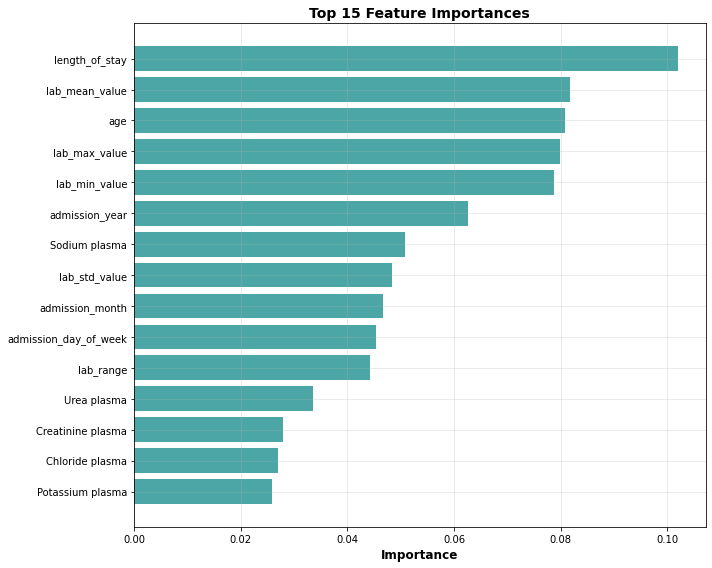


✓ Feature importances saved


In [5]:
if hasattr(model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print('Top 15 Most Important Features:')
    print(importance_df.head(15))
    
    plt.figure(figsize=(10, 8))
    top_15 = importance_df.head(15)
    plt.barh(range(15), top_15['Importance'], color='teal', alpha=0.7)
    plt.yticks(range(15), top_15['Feature'])
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    importance_df.to_csv('output/feature_importances.csv', index=False)
    print('\n✓ Feature importances saved')

## Confidence Analysis

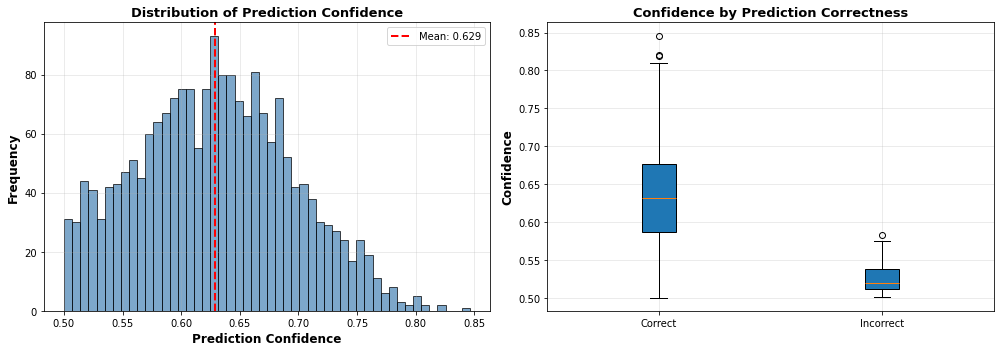


Average confidence for correct predictions: 0.633
Average confidence for incorrect predictions: 0.525


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(results_df['Confidence'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(results_df['Confidence'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {results_df["Confidence"].mean():.3f}')
axes[0].set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Prediction Confidence', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

correct = results_df['Actual'] == results_df['Predicted']
conf_correct = results_df[correct]['Confidence']
conf_incorrect = results_df[~correct]['Confidence']

axes[1].boxplot([conf_correct, conf_incorrect], labels=['Correct', 'Incorrect'], patch_artist=True)
axes[1].set_ylabel('Confidence', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence by Prediction Correctness', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nAverage confidence for correct predictions: {conf_correct.mean():.3f}')
print(f'Average confidence for incorrect predictions: {conf_incorrect.mean():.3f}')

## High-Risk Patients

In [7]:
high_risk = results_df[results_df['Probability_Disease'] > 0.7].sort_values('Probability_Disease', ascending=False)

print(f'High-risk patients (probability > 0.7): {len(high_risk)}')
print('\nTop 10 highest risk patients:')
print(high_risk[['ID', 'Actual', 'Predicted', 'Probability_Disease', 'Confidence']].head(10))

high_risk.to_csv('output/high_risk_patients.csv', index=False)
print('\n✓ High-risk patients list saved')

High-risk patients (probability > 0.7): 127

Top 10 highest risk patients:
        ID  Actual  Predicted  Probability_Disease  Confidence
1205  4085       1          1             0.846175    0.846175
775   9895       1          1             0.819285    0.819285
14    1162       1          1             0.810517    0.810517
1784  8397       1          1             0.806139    0.806139
1945  9570       1          1             0.802143    0.802143
1122  3456       1          1             0.800979    0.800979
290   4507       1          1             0.798683    0.798683
184   3165       1          1             0.796256    0.796256
1523  6386       1          1             0.793086    0.793086
243   3980       1          1             0.787777    0.787777

✓ High-risk patients list saved


## Summary

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('='*80)
print('PREDICTION SUMMARY')
print('='*80)
print(f'\nTotal predictions: {len(predictions)}')
print(f'Accuracy: {accuracy_score(y, predictions):.4f}')
print(f'Precision: {precision_score(y, predictions):.4f}')
print(f'Recall: {recall_score(y, predictions):.4f}')
print(f'F1 Score: {f1_score(y, predictions):.4f}')
print(f'\nHigh-risk patients identified: {len(high_risk)}')
print(f'Average prediction confidence: {results_df["Confidence"].mean():.3f}')
print('='*80)

PREDICTION SUMMARY

Total predictions: 2000
Accuracy: 0.9605
Precision: 0.9891
Recall: 0.9292
F1 Score: 0.9582

High-risk patients identified: 127
Average prediction confidence: 0.629
